In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import pandas as pd
import sklearn.model_selection
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
def stringToDateTime(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return dt.datetime.strptime(datetime, '%Y-%m-%d %H:%M:%S')

In [3]:
def datetimeToFloat(columns):
    d=columns[0]
    return d.timestamp()

In [4]:
def extractMonth(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return datetime.month

In [5]:
def extractdayOfWeek(columns):
    date=columns[0]
    if pd.isnull(date):
        return date
    else:
        return date.weekday()

In [6]:
def extractday(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return datetime.day

In [7]:
def formatDate(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return str(datetime.day)+'/'+str(datetime.month)+'/'+str(datetime.year)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
#Read the data
data=pd.read_csv('1.csv', delimiter='\t')

In [10]:
#Check the number of data and its datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 2 columns):
time       517 non-null object
Visitor    517 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.2+ KB


In [11]:
#Check the number of null values
data.isnull().sum()

time       0
Visitor    0
dtype: int64

In [12]:
#Convert date string to datetime object
data['time']=data[['time']].apply(stringToDateTime,axis=1)

In [13]:
#Extract day from datetime
data['day']=data[['time']].apply(extractday,axis=1)

In [14]:
#Extract month
data['month']=data[['time']].apply(extractMonth,axis=1)

In [15]:
#Extract day of the week
data['dayOfWeek']=data[['time']].apply(extractdayOfWeek,axis=1)

In [16]:
#Format the datetime for graph
data['formattedDate']=data[['time']].apply(formatDate,axis=1)

In [17]:
#Convert the datetime to time from epoch time
data['time']=data[['time']].apply(datetimeToFloat,axis=1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 6 columns):
time             517 non-null float64
Visitor          517 non-null int64
day              517 non-null int64
month            517 non-null int64
dayOfWeek        517 non-null int64
formattedDate    517 non-null object
dtypes: float64(1), int64(4), object(1)
memory usage: 24.3+ KB


In [19]:
#Create dummy variables for categorical day of the week
dayOfWeekDumyList = pd.get_dummies(data['dayOfWeek'], prefix='dayOfWeek')
data=data.join(dayOfWeekDumyList)
data=data.drop('dayOfWeek',axis=1)

In [20]:
#Create dummy variables for categorical month
monthDumyList = pd.get_dummies(data['month'], prefix='month')
data=data.join(monthDumyList)
data=data.drop('month',axis=1)

In [21]:
#Create dummy variables for categorical day
dayDumyList = pd.get_dummies(data['day'], prefix='day')
data=data.join(dayDumyList)
data=data.drop('day',axis=1)

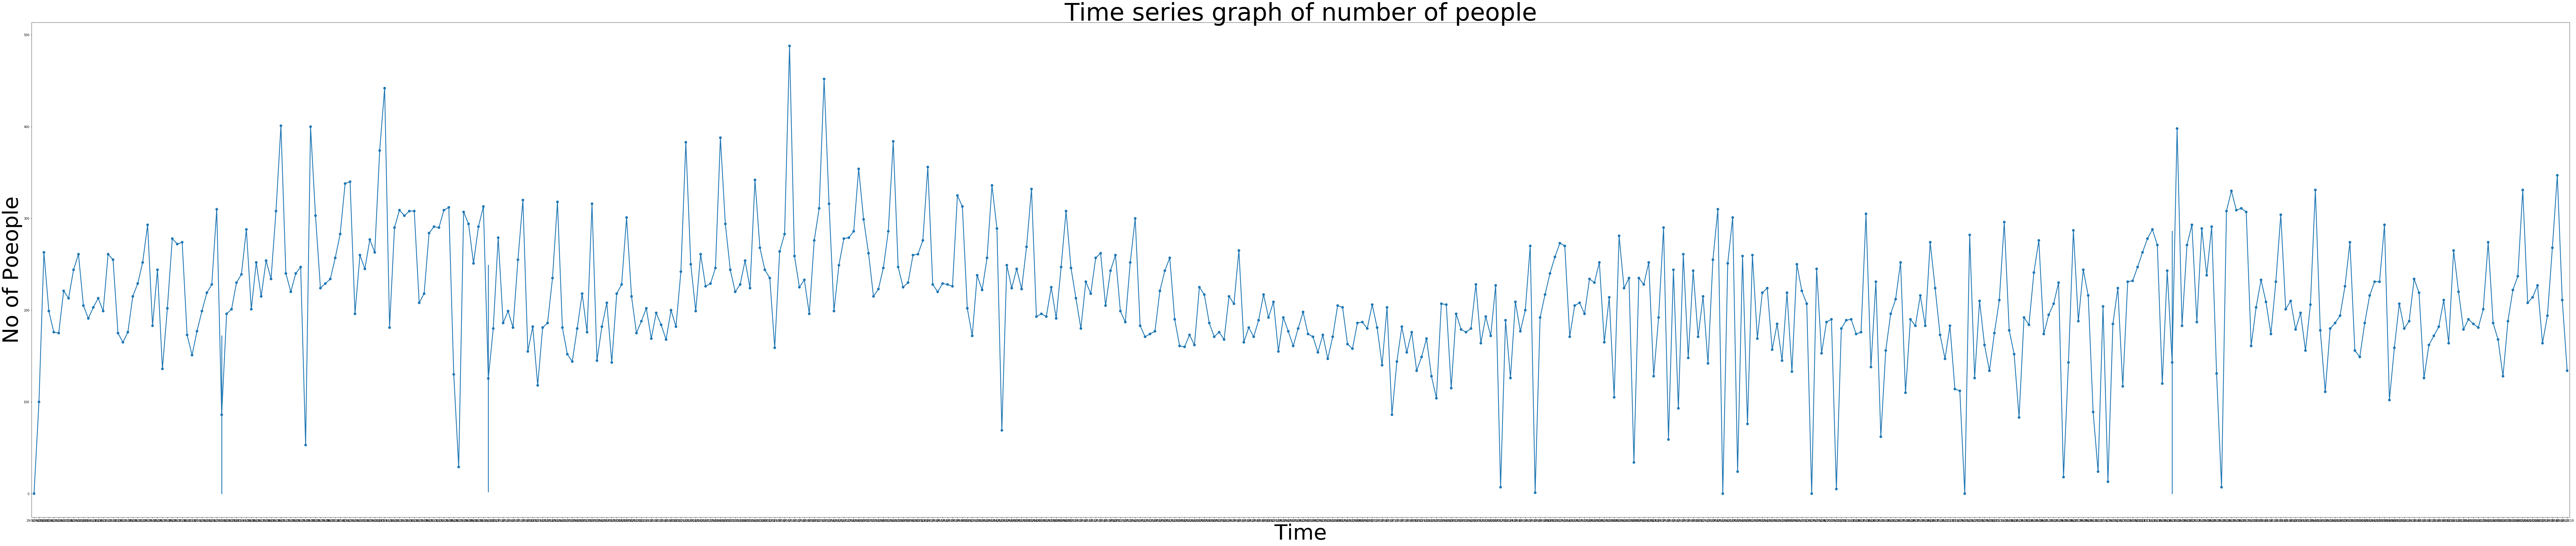

In [22]:
#Plot the graph No of people against Time
mpl.rcParams['figure.figsize']=150,30
fig=sns.pointplot(x='formattedDate',y='Visitor',data=data)
fig.set_xlabel('Time',fontsize=70)
fig.set_ylabel('No of Poeople',fontsize=70)
fig.axes.set_title('Time series graph of number of people',fontsize=80)
plt.show()

In [23]:
#Drop time and formatted date from the data
data=data.drop('time',axis=1)
data=data.drop('formattedDate',axis=1)

In [24]:
#Normalise data to 0 to 1 range
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [25]:
#Split training and testing data
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
X_train, X_test = pd.DataFrame(data[0:train_size,:]), pd.DataFrame(data[train_size:len(data),:])
X_train=X_train.values
X_test=X_test.values
X_train.shape

(413, 51)

In [26]:
#Define the dimension,batch size and epochs of neural network
original_dim=X_train.shape[-1]
first_dim=int((3*original_dim)/4)
second_dim=int((3*first_dim)/4)
third_dim=int((3*second_dim)/4)

batch_size = 100
latent_dim=2
epochs = 100
epsilon_std=1.0

In [27]:
#Encoder layer definition
x = Input(shape=(original_dim,))
x1=Dense(first_dim,activation='relu')(x)
x2=Dense(second_dim,activation='relu')(x1)
x3=Dense(third_dim,activation='relu')(x2)

In [28]:
#Latent/Middle layer definitions with data recreation and sampling
z_mean = Dense(latent_dim)(x3)
z_log_var = Dense(latent_dim)(x3)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [29]:
#Decoder definition
decoder_t = Dense(third_dim, activation='relu')
decoder_s = Dense(second_dim, activation='relu')
decoder_f = Dense(first_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_t(z)
h_decoded = decoder_s(h_decoded)
h_decoded = decoder_f(h_decoded)

x_decoded_mean = decoder_mean(h_decoded)

In [30]:
# instantiate VAE model
vae = Model(x, x_decoded_mean)

In [31]:
# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [32]:
#Add VAE loss, compile the model and display the summary
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 51)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 38)           1976        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 28)           1092        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 21)           609         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "dense_9" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_9" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
#Convert the data to float and rehape to three dimension again
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [34]:
#Fit or Run the model
vae.fit(X_train,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/100
413/413 [==============================] - 0s 307us/step - loss: 35.0076
Epoch 2/100
413/413 [==============================] - 0s 45us/step - loss: 33.5506
Epoch 3/100
413/413 [==============================] - 0s 75us/step - loss: 31.5856
Epoch 4/100
413/413 [==============================] - 0s 59us/step - loss: 29.1175
Epoch 5/100
413/413 [==============================] - 0s 68us/step - loss: 25.9163
Epoch 6/100
413/413 [==============================] - 0s 55us/step - loss: 23.0885
Epoch 7/100
413/413 [==============================] - 0s 37us/step - loss: 20.7759
Epoch 8/100
413/413 [==============================] - 0s 42us/step - loss: 18.8454
Epoch 9/100
413/413 [==============================] - 0s 47us/step - loss: 17.4987
Epoch 10/100
413/413 [==============================] - 0s 41us/step - loss: 16.4966
Epoch 11/100
413/413 [==============================] - 0s 39us/step - loss: 15.7583
Epoch 12/100
413/413 [==============================] - 0s 37us/step - lo

413/413 [==============================] - 0s 41us/step - loss: 11.3895
Epoch 98/100
413/413 [==============================] - 0s 43us/step - loss: 11.3859
Epoch 99/100
413/413 [==============================] - 0s 46us/step - loss: 11.3843
Epoch 100/100
413/413 [==============================] - 0s 44us/step - loss: 11.3966


In [35]:
#Predict values based on test dataset
preds = vae.predict(X_test, batch_size=batch_size)

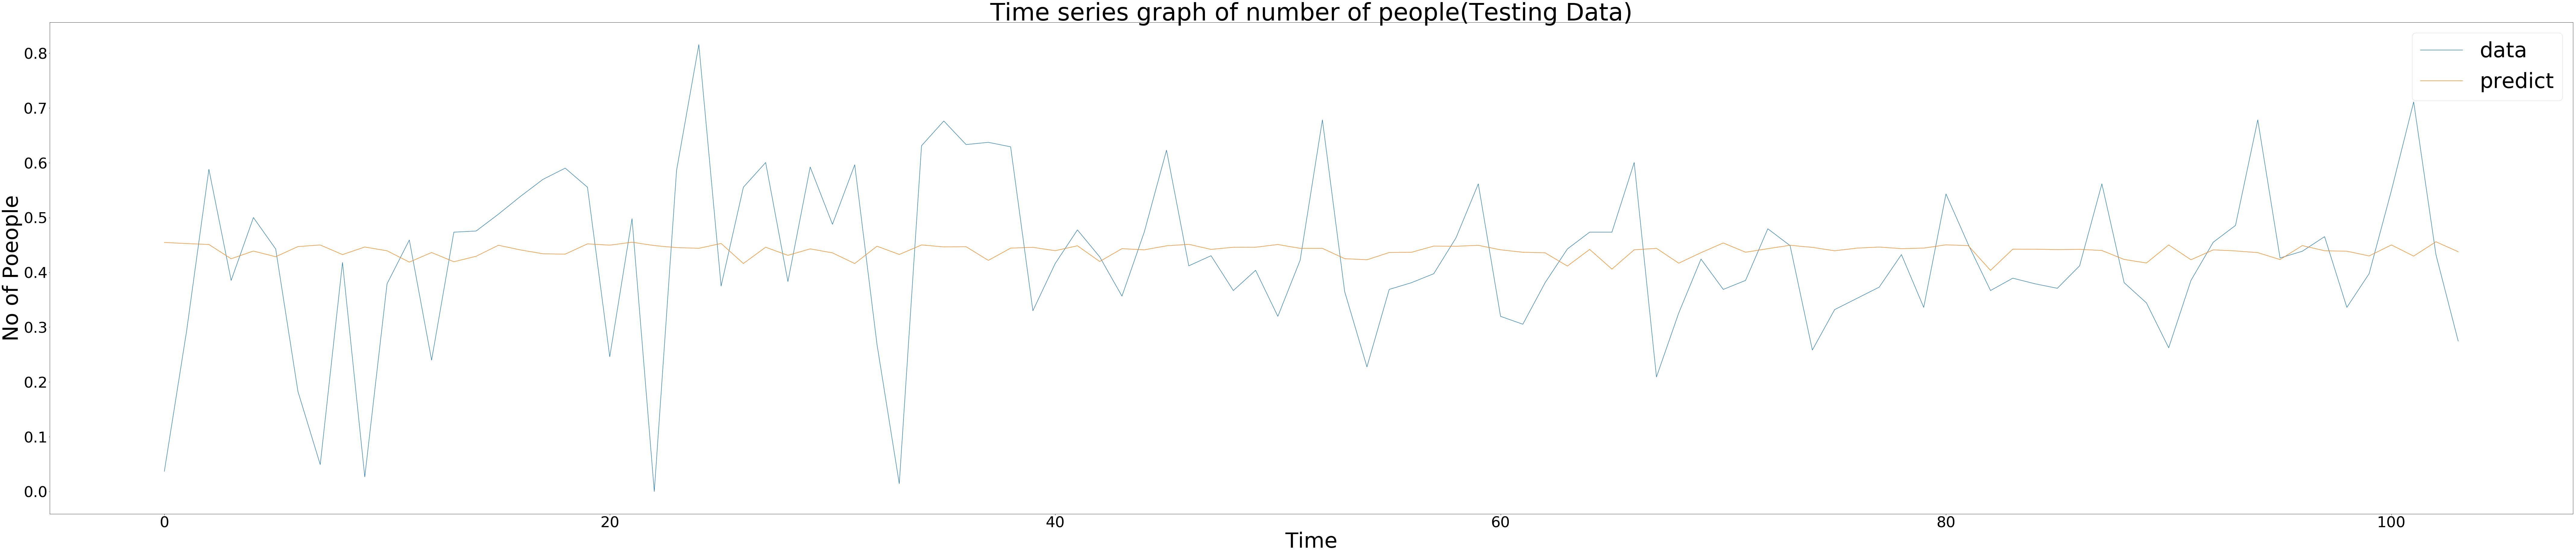

In [36]:
#Plot test dataset and predicted dataset based on test dataset
plt.plot(X_test[:,0], label='data')
plt.plot(preds[:,0], label='predict')
plt.xlabel('Time',fontsize=70)
plt.ylabel('No of Poeople',fontsize=70)
plt.tick_params(labelsize=50)
plt.title('Time series graph of number of people(Testing Data)',fontsize=80)
plt.legend(fontsize=70)
plt.show()

In [37]:
#Predict values based on train dataset
preds = vae.predict(X_train, batch_size=batch_size)

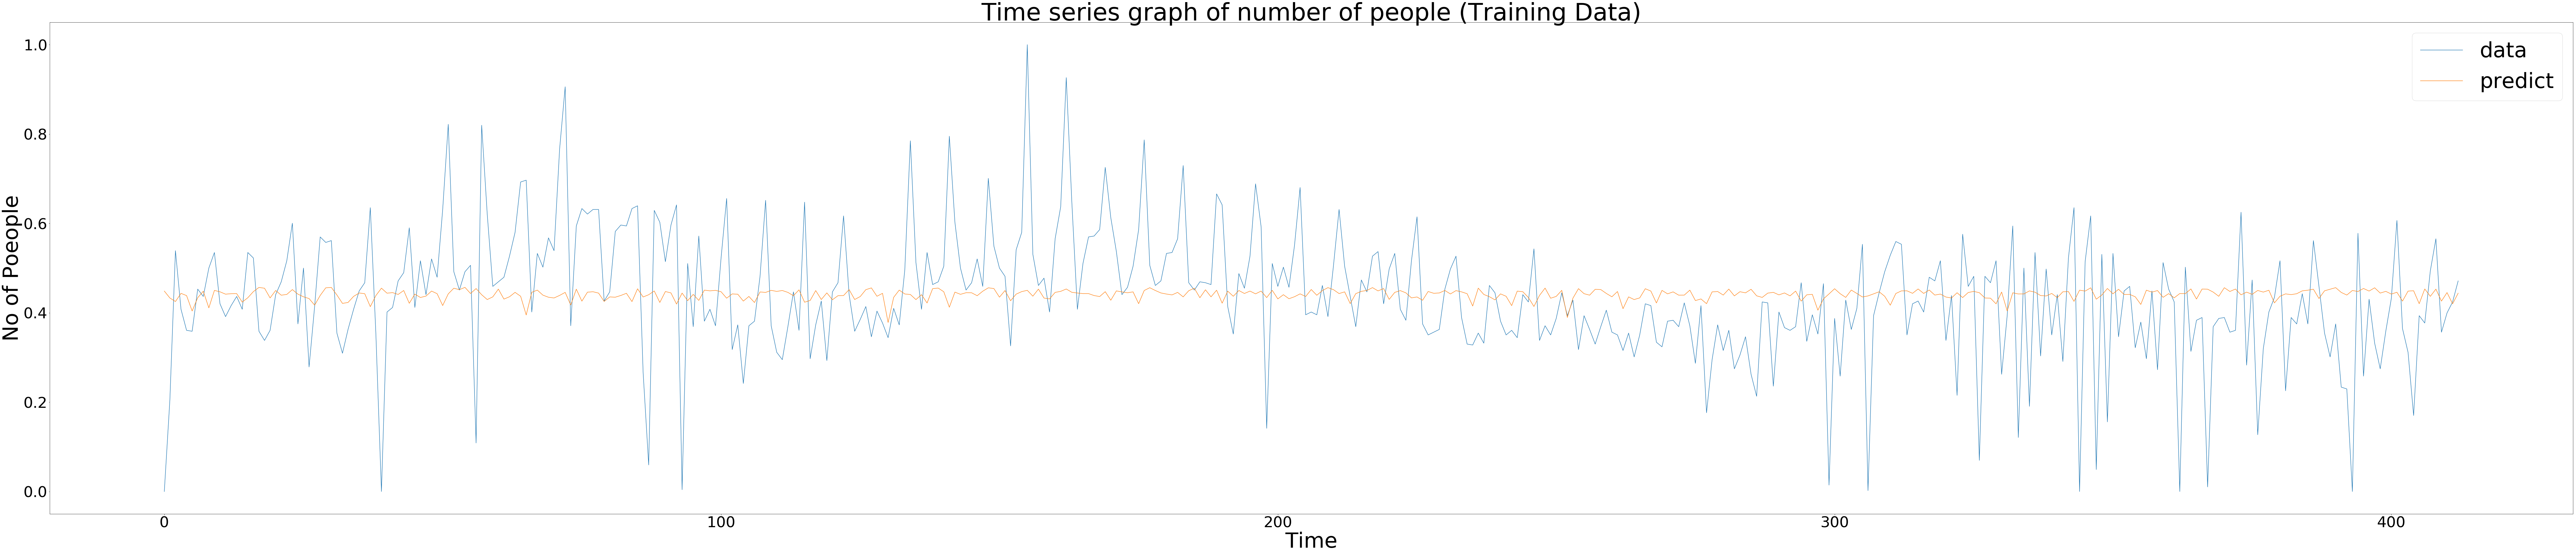

In [38]:
#Plot test dataset and predicted dataset based on train dataset
plt.plot(X_train[:,0], label='data')
plt.plot(preds[:,0], label='predict')
plt.xlabel('Time',fontsize=70)
plt.ylabel('No of Poeople',fontsize=70)
plt.tick_params(labelsize=50)
plt.title('Time series graph of number of people (Training Data)',fontsize=80)
plt.legend(fontsize=70)
plt.show()